In [2]:
import tensorflow as tf 
import numpy as np
import pandas as pd 
import os 
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.applications import xception
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

Hyperparameter

In [3]:
input_dim=(150,150,3)
classes=1
patience=5
ePOCH=10

In [4]:
filenames= os.listdir('./train')
labels=[] 
for name in filenames:
    list_of_split_name= name.split('.')[0] 
    if list_of_split_name == 'dog':       
        labels.append('dog')        
    else:             
        labels.append('cat') 

In [5]:
df_train= pd.DataFrame({ 'filename' : filenames ,'label': labels}) 
df_test= pd.DataFrame({ 'filename' : filenames ,'label': labels})
df_train['label'].map({'dog': 0, 'cat': 1}) 
df_train['label'].value_counts()

cat    2984
dog    2935
Name: label, dtype: int64

In [7]:
train_df, valid_df = train_test_split(df_train , test_size= 0.3 , random_state= 42, stratify=df_train['label'], shuffle=True)  
train_df= train_df.reset_index(drop=True)   
valid_df= valid_df.reset_index(drop=True)

In [8]:
train_data= keras.preprocessing.image.ImageDataGenerator(rescale=1./255 ,                                                          
                                                         rotation_range=20,                                                          
                                                         horizontal_flip=True,                                                          
                                                         vertical_flip=True,
                                                        validation_split=0.2) 
train_generator=train_data.flow_from_dataframe( dataframe=train_df,                                                 
                                                directory='./train',                                                
                                               target_size=(input_dim[0], input_dim[1]),                                                 
                                               x_col="filename",                                                 
                                               y_col="label",                                                 
                                               color_mode="rgb",                                                 
                                               class_mode="binary",                                                 
                                               batch_size=32,                                                 
                                               seed = 42,                                                 
                                               shuffle=True,
                                               subset='training'
                                               )

Found 3315 validated image filenames belonging to 2 classes.


In [9]:
valid_data=keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                       validation_split=0.2)  
valid_generator=valid_data.flow_from_dataframe( dataframe=valid_df,
                                               directory='./train',
                                               target_size=(input_dim[0], input_dim[1]),
                                               x_col="filename",
                                               y_col="label",
                                               color_mode="rgb",
                                               class_mode="binary",
                                               batch_size=32,
                                               seed = 42,
                                               shuffle=True,
                                               subset='validation')

Found 355 validated image filenames belonging to 2 classes.


In [10]:
filenames = os.listdir("./test1") 
test_df = pd.DataFrame({'filename' : filenames})     
test_df.head()

,filename
0,9733.jpg
1,63.jpg
2,6400.jpg
3,823.jpg
4,4217.jpg


In [11]:
test_data=keras.preprocessing.image.ImageDataGenerator(rescale=1./255)  
test_generator=test_data.flow_from_dataframe( dataframe=test_df,
                                              directory='./test1',
                                              target_size=(input_dim[0], input_dim[1]),
                                              x_col="filename",
                                              class_mode=None,
                                              batch_size=32,
                                              seed = 42)

Found 12500 validated image filenames.


Rework Xeception

In [12]:
def conv_block(x, filters, block_num, conv_num, strides=(1,1)):
    name = 'block{}_conv{}_'.format(block_num, conv_num)     
    # conv-BN-relu 
    x = tf.keras.layers.Conv2D(filters, (3,3), strides=strides, use_bias=False, name=name)(x) 
    x = tf.keras.layers.BatchNormalization(name=name+'bn')(x)   
    x = tf.keras.layers.Activation('relu', name=name+'act')(x)     
    return x

In [14]:
def separable_conv_block(x, filters, block_num, conv_num, pre_activation=None): 
    name = 'block{}_sepconv{}_'.format(block_num, conv_num)     
    if pre_activation is True:        
        x = tf.keras.layers.Activation('relu', name=name+'act')(x)      
    # (relu)-sepconv-BN-(relu)  
    x = tf.keras.layers.SeparableConv2D(filters, (3,3), padding='same', use_bias=False, name=name)(x)   
    x = tf.keras.layers.BatchNormalization(name=name+'bn')(x)  
    
    if pre_activation is False:        
        x = tf.keras.layers.Activation('relu', name=name+'act')(x)      
    return x

In [15]:
def middle_flow_block(x, filters, block_num):     
    # middle flow    
    residual = x     
    x = separable_conv_block(x, filters, block_num=block_num, conv_num='1', pre_activation=True)  
    x = separable_conv_block(x, filters, block_num=block_num, conv_num='2', pre_activation=True)   
    x = separable_conv_block(x, filters, block_num=block_num, conv_num='3', pre_activation=True)      
    return tf.keras.layers.add([x, residual])

In [16]:
def xception_block(x, filters, block_num, pre_activation=True):   
    block = 'block{}_'.format(block_num)    
    filter_conv1, filter_conv2 = filters     
    # residual conv branch     
    residual = tf.keras.layers.Conv2D(filter_conv2, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)   
    residual = tf.keras.layers.BatchNormalization()(residual)     
    # separable conv block  
    x = separable_conv_block(x, filter_conv1, block_num=block_num, conv_num='1', pre_activation=pre_activation)  
    x = separable_conv_block(x, filter_conv2, block_num=block_num, conv_num='2', pre_activation=True)     
    # downsampling and merging   
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name=block+'pool')(x)     
    return tf.keras.layers.add([x, residual])

In [17]:
def Xception(input_shape=input_dim, classes=classes):     
    """Instantiates the Xception architecture.
    """      
    img_input = tf.keras.layers.Input(shape=input_shape)      
    #===========ENTRY FLOW==============    
    #Block 1    
    x = conv_block(img_input, 32, block_num='1', conv_num='1', strides=(2,2))     
    x = conv_block(x, 64, block_num='1', conv_num='2')     
    #Block 2
    x = xception_block(x, (128, 128), '2', pre_activation=None)      
    #Block 3     
    x = xception_block(x, (256, 256), '3')      
    #Block 4     
    x = xception_block(x, (728, 728), '4')       
    #===========MIDDLE FLOW=============== 
    for i in range(8):         
        block_num = str(5+i)         
        x = middle_flow_block(x, 728, block_num)      
    #========EXIT FLOW============    
    #Block 13     
    x = xception_block(x, (728, 1024), '13') 
    # second conv is different  
    # Block 14    
    x = separable_conv_block(x, 1536, block_num='14', conv_num='1', pre_activation=False)
    x = separable_conv_block(x, 2048, block_num='14', conv_num='2', pre_activation=False)      
    # logistic regression    
    x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)    
    x = tf.keras.layers.Dense(classes, activation='sigmoid', name='predictions')(x)     
    # Create model.
    model = tf.keras.Model(inputs=img_input, outputs=x, name='xception')    
    return model

In [18]:
rework_model = Xception() 
rework_model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-10-16 15:49:45.588463: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-16 15:49:45.588656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1_ (Conv2D)         (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1_[0][0]']          
 ation)                                                                                           
                                                                                           

Default Xeception

In [19]:
orig_model = xception.Xception(weights='imagenet', include_top=False, input_shape=input_dim)
x = orig_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x) 
# add a fully-connected layer    
x = tf.keras.layers.Dense(classes, activation='sigmoid')(x)    
# model   
model = tf.keras.Model(inputs=orig_model.input, outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [17]:
for model, rework_layer in zip(model.layers, rework_model.layers):
    model.trainable = True        
    rework_layer.set_weights(model.get_weights())

In [18]:
rework_model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.BinaryCrossentropy(),  
    metrics=['accuracy'] ) 
tb = tf.keras.callbacks.TensorBoard(log_dir='./logs')
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath='file_name/cp.h5',
                                                 save_weights_only=False,
                                                 verbose=1,
                                                 monitor='val_accuracy',
                                                 save_best_only=True)
EarlyStopping=tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
# checkpoint = ModelCheckpoint(filepath='file_name',monitor='val_accuracy',mode='auto' ,save_best_only=True,save_freq='epoch')   
early_stop=tf.keras.callbacks.EarlyStopping(patience=patience, monitor = 'val_accuracy')
callback_lists=[tb,checkpoint,early_stop,EarlyStopping]   
history = rework_model.fit(     
                    train_generator,
                    epochs=ePOCH,     
                    validation_data=valid_generator, 
                    verbose=True,
                    callbacks=callback_lists)

Epoch 1/10


2022-10-16 15:44:07.586719: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-16 15:44:09.866214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - ETA: 0s - loss: 0.3162 - accuracy: 0.8679

2022-10-16 15:46:59.989265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.92113, saving model to file_name/cp.h5
104/104 [==============================] - 179s 2s/step - loss: 0.3162 - accuracy: 0.8679 - val_loss: 1.0281 - val_accuracy: 0.9211
Epoch 2/10
 17/104 [===>..........................] - ETA: 2:28 - loss: 0.2616 - accuracy: 0.8989

In [ ]:
for i, layer in enumerate(rework_model.layers):    
    print(i, layer.name)

0 input_1
1 block1_conv1_
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2_
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1_
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2_
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1_
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2_
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1_
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2_
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1_
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2_
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3_
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1_
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2_
51 block6_sepconv2_bn
52 block6

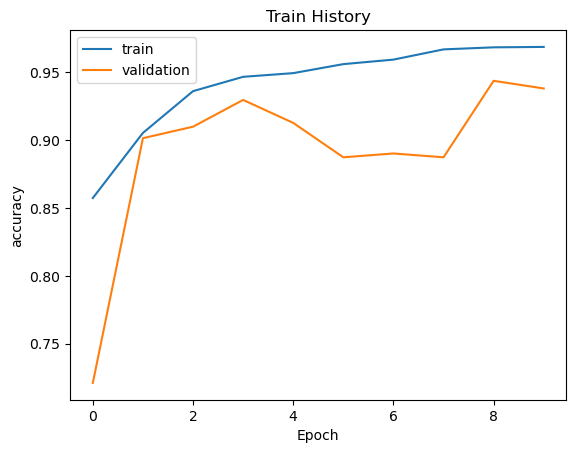

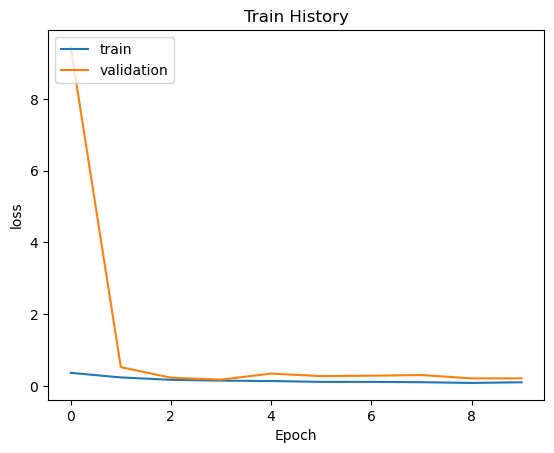

In [ ]:
def show_train_history(train_history, train, validation):        
    plt.plot(train_history.history[train])        
    plt.plot(train_history.history[validation])        
    plt.title('Train History')        
    plt.ylabel(train)        
    plt.xlabel('Epoch')        
    plt.legend(['train', 'validation'], loc='upper left')        
    plt.show()        
    # 画出准确率执行结果  
show_train_history(history, 'accuracy', 'val_accuracy')  
    # 画出误差执行结果  
show_train_history(history, 'loss', 'val_loss')

In [20]:
from keras.models import load_model
model = load_model('./file_name/cp.h5') 
# model = create_model()
# model.load_weights('./file_name/checkpoint')
loss,acc = model.evaluate(valid_generator,batch_size=32,verbose=0)   
print('test_loss',loss,'test_accuracy',acc)

2022-10-16 15:51:12.009365: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-16 15:51:12.305397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


test_loss 1.0281295776367188 test_accuracy 0.9211267828941345


In [21]:
predict = model.predict(test_generator)
predict = [1 if x > 0.5 else 0 for x in predict]
test_df['category'] = predict  

2022-10-16 15:51:21.844459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


391/391 [==============================] - 168s 430ms/step


In [33]:
submission_df = test_df.copy() 
submission_df['id'] = submission_df['filename'].str.split('.').str[0] 
submission_df['label'] = submission_df['category'] 
submission_df.drop(['filename', 'category'], axis=1,inplace=True) 
submission_df.to_csv('submission.csv', index=False)

In [34]:
submission_df.shape

(12500, 2)